This notebook implements MOBOLFI and BOLFI on inference of transmission dynamics of bacteria in day care centers. See details in paper Numminen, E., Cheng, L., Gyllenberg, M. and Corander, J.: Estimating the transmission dynamics of Streptococcus pneumoniae from strain prevalence data, Biometrics, 69, 748-757, 2013. 

In [358]:
"""Example of inference of transmission dynamics of bacteria in day care centers.

Treatment roughly follows:
Numminen, E., Cheng, L., Gyllenberg, M. and Corander, J.: Estimating the transmission dynamics
of Streptococcus pneumoniae from strain prevalence data, Biometrics, 69, 748-757, 2013.
"""

import logging
from functools import partial

import numpy as np


def daycare(t1, t2, t3, n_dcc=29, n_ind=53, n_strains=33, freq_strains_commun=None,
            n_obs=36, time_end=10., batch_size=1, random_state=None):
    r"""Generate cross-sectional data from a stochastic variant of the SIS-model.

    This function simulates the transmission dynamics of bacterial infections in daycare centers
    (DCC) as described in Nummelin et al. [2013]. The observation model is however simplified to
    an equal number of sampled individuals among the daycare centers.

    The model is defined as a continuous-time Markov process with transition probabilities:

    Pr(I_{is}(t+dt)=1 | I_{is}(t)=0) = t1 * E_s(I(t)) + t2 * P_s, if \sum_{j=1}^N_s I_{ij}(t)=0
    Pr(I_{is}(t+dt)=1 | I_{is}(t)=0) = t3 * (t1 * E_s(I(t)) + t2 * P_s), otherwise
    Pr(I_{is}(t+dt)=0 | I_{is}(t)=1) = \gamma

    where:
    I_{is}(t) is the status of carriage of strain s for individual i.
    E_s(I(t)) is the probability of sampling the strain s
    t1 is the rate of transmission from other children at the DCC (\beta in paper).
    t2 is the rate of transmission from the community outside the DCC (\Lambda in paper).
    t3 scales the rate of an infected child being infected with another strain (\theta in paper).
    \gamma is the relative probability of healing from a strain.

    As in the paper, \gamma=1, and the other inferred parameters are relative to it.

    The system is solved using the Direct method [Gillespie, 1977].

    References
    ----------
    Numminen, E., Cheng, L., Gyllenberg, M. and Corander, J. (2013) Estimating the transmission
        dynamics of Streptococcus pneumoniae from strain prevalence data, Biometrics, 69, 748-757.
    Gillespie, D. T. (1977) Exact stochastic simulation of coupled chemical reactions.
        The Journal of Physical Chemistry 81 (25), 2340–2361.

    Parameters
    ----------
    t1 : float or np.array
        Rate of transmission from other individuals at the DCC.
    t2 : float or np.array
        Rate of transmission from the community outside the DCC.
    t3 : float or np.array
        Scaling of co-infection for individuals infected with another strain.
    n_dcc : int, optional
        Number of daycare centers.
    n_ind : int, optional
        Number of individuals in a DCC (same for all).
    n_strains : int, optional
        Number of bacterial strains considered.
    freq_strains_commun : np.array of shape (n_strains,), optional
        Prevalence of each strain in the community outside the DCC. Defaults to 0.1.
    n_obs : int, optional
        Number of individuals sampled from each DCC (same for all).
    time_end : float, optional
        The system is solved using the Direct method until all cases within the batch exceed this.
    batch_size : int, optional
    random_state : np.random.RandomState, optional

    Returns
    -------
    state_obs : np.array
        Observations in shape (batch_size, n_dcc, n_obs, n_strains).

    """
    random_state = random_state or np.random

    t1 = np.asanyarray(t1).reshape((-1, 1, 1, 1))
    t2 = np.asanyarray(t2).reshape((-1, 1, 1, 1))
    t3 = np.asanyarray(t3).reshape((-1, 1, 1, 1))

    if freq_strains_commun is None:
        freq_strains_commun = np.full(n_strains, 0.1)

    prob_commun = t2 * freq_strains_commun

    # the state (infection status) is a 4D tensor for computational performance
    state = np.zeros((batch_size, n_dcc, n_ind, n_strains), dtype=np.bool_)

    # time for each DCC in the batch
    time = np.zeros((batch_size, n_dcc))

    n_factor = 1. / (n_ind - 1)
    gamma = 1.  # relative, see paper
    ind_b_dcc = [np.repeat(np.arange(batch_size), n_dcc), np.tile(np.arange(n_dcc), batch_size)]

    while np.any(time < time_end):
        with np.errstate(divide='ignore', invalid='ignore'):
            # probability of sampling a strain; in paper: E_s(I(t))
            prob_strain_adjust = np.nan_to_num(state / np.sum(state, axis=3, keepdims=True))
            prob_strain = np.sum(prob_strain_adjust, axis=2, keepdims=True)

        # Which individuals are already infected:
        intrainfect_rate = t1 * (np.tile(prob_strain, (1, 1, n_ind, 1)) -
                                 prob_strain_adjust) * n_factor + 1e-9

        # init prob to get infected, same for all
        hazards = intrainfect_rate + prob_commun  # shape (batch_size, n_dcc, 1, n_strains)

        # co-infection, depends on the individual's state
        # hazards = np.tile(hazards, (1, 1, n_ind, 1))
        any_infection = np.any(state, axis=3, keepdims=True)
        hazards = np.where(any_infection, t3 * hazards, hazards)

        # (relative) probability to be cured
        hazards[state] = gamma

        # normalize to probabilities
        inv_sum_hazards = 1. / np.sum(hazards, axis=(2, 3), keepdims=True)
        probs = hazards * inv_sum_hazards

        # times until next transition (for each DCC in the batch)
        delta_t = random_state.exponential(inv_sum_hazards[:, :, 0, 0])
        time = time + delta_t

        # choose transition
        probs = probs.reshape((batch_size, n_dcc, -1))
        cumprobs = np.cumsum(probs[:, :, :-1], axis=2)
        x = random_state.uniform(size=(batch_size, n_dcc, 1))
        ind_transit = np.sum(x >= cumprobs, axis=2)

        # update state, need to find the correct indices first
        ind_transit = ind_b_dcc + list(np.unravel_index(ind_transit.ravel(), (n_ind, n_strains)))
        state[tuple(ind_transit)] = np.logical_not(state[tuple(ind_transit)])

    # observation model: simply take the first n_obs individuals
    state_obs = state[:, :, :n_obs, :]

    return state_obs






Define the ground truth parameter. Below the synthetic data simulated by ground truth parameter is called as the "real data".

In [359]:
true_params = [3.6, 0.6, 0.1]
real_data = daycare(*true_params)

In [360]:
real_data.shape

(1, 29, 36, 33)

There is only one data source in this example. In BOLFI paper (Gutmann M U, Corander J (2016). Bayesian Optimization for Likelihood-Free Inference of Simulator-Based Statistical Models. JMLR 17(125):1−47, 2016.), four summary statistics are calculated and the training objective (discrepancy) function is defined to be L1-norm between four summaries of simulated data and four summaries of observed "real data".

There is no scaling applied to the discrepancy in this example. However, following the idea of BOLFI paper, we normalize (rounded to 1 decimal place) the four data summaries before calculating the discrepancy in order to put all elements of discrepancy on a similar scale for observed data. (Note in BOLFI paper, the normalization is done to let the maximal value of each of the four summaries be one for observed data. The default scaling strategy here is slightly different.)

In [902]:
def ss_shannon(data):
    r"""Calculate the Shannon index of diversity of the distribution of observed strains.

    H = -\sum p \log(p)

    https://en.wikipedia.org/wiki/Diversity_index#Shannon_index

    Parameters
    ----------
    data : np.array of shape (batch_size, n_dcc, n_obs, n_strains)

    Returns
    -------
    np.array of shape (batch_size, n_dcc)

    """
    total_obs = np.sum(data, axis=2, keepdims=True)
    with np.errstate(divide='ignore', invalid='ignore'):
        proportions = np.nan_to_num(total_obs / np.sum(total_obs, axis=3, keepdims=True))
    proportions[proportions == 0] = 1
    shannon = (-np.sum(proportions * np.log(proportions), axis=3))[:, :, 0]

    return shannon


def ss_strains(data):
    """Calculate the number of different strains observed.

    Parameters
    ----------
    data : np.array of shape (batch_size, n_dcc, n_obs, n_strains)

    Returns
    -------
    np.array of shape (batch_size, n_dcc)

    """
    strain_active = np.any(data, axis=2)
    n_strain_obs = np.sum(strain_active, axis=2)  # axis 3 is now 2

    return n_strain_obs


def ss_prevalence(data):
    """Calculate the prevalence of carriage among the observed individuals.

    Parameters
    ----------
    data : np.array of shape (batch_size, n_dcc, n_obs, n_strains)

    Returns
    -------
    np.array of shape (batch_size, n_dcc)

    """
    any_infection = np.any(data, axis=3)
    n_infected = np.sum(any_infection, axis=2)

    return n_infected / data.shape[2]


def ss_prevalence_multi(data):
    """Calculate the prevalence of multiple infections among the observed individuals.

    Parameters
    ----------
    data : np.array of shape (batch_size, n_dcc, n_obs, n_strains)

    Returns
    -------
    np.array of shape (batch_size, n_dcc)

    """
    n_infections = np.sum(data, axis=3)
    n_multi_infections = np.sum(n_infections > 1, axis=2)

    return n_multi_infections / data.shape[2]


def distance_bolfi(*summaries, observed):
    """Calculate an L1-based distance between the simulated and observed summaries.

    Follows the simplified single-distance approach in:
    Gutmann M U, Corander J (2016). Bayesian Optimization for Likelihood-Free Inference
    of Simulator-Based Statistical Models. JMLR 17(125):1−47, 2016.

    Parameters
    ----------
    *summaries : k np.arrays of shape (m, n)
    observed : list of k np.arrays of shape (1, n)

    Returns
    -------
    np.array of shape (m,)

    """
    summaries = np.stack(summaries)
    observed = np.stack(observed)
    n_ss, _, n_dcc = summaries.shape

    obs_max = np.max(observed, axis=2, keepdims=True)
    obs_max = np.where(obs_max == 0, 1, obs_max)

    y = observed / obs_max
    x = summaries / obs_max

    # sort to make comparison more robust
    y = np.sort(y, axis=2)
    x = np.sort(x, axis=2)
    # L1 norm divided by the dimension
    dist = np.sum(np.abs(x - y), axis=2) / (n_ss * n_dcc)
    dist[3] *= 0.1 # With finite number of simulations, we find the first 3 elments of dist (correspond to first 3 summries) values approximately 10 times smaller than the fourth summary. Thus scale the fourth element 0.1
    dist = np.sum(dist,axis = 0)
    # dist = np.sum(np.abs(x - y), axis=(0, 2)) / (n_ss * n_dcc)

    return dist*-1

In [903]:
obs_summary_list = [ss_shannon(real_data), ss_strains(real_data), ss_prevalence(real_data), ss_prevalence_multi(real_data)]
test_params = [4.5, 0.6, 0.1]
test_data = daycare(*test_params)
distance_bolfi(ss_shannon(test_data), ss_strains(test_data), ss_prevalence(test_data), ss_prevalence_multi(test_data), observed=obs_summary_list)

array([-0.02257012])

In [904]:
test_params = true_params
# true_params = [3.6, 0.6, 0.1]
test_data = daycare(*test_params)
distance_bolfi(ss_shannon(test_data), ss_strains(test_data), ss_prevalence(test_data), ss_prevalence_multi(test_data), observed=obs_summary_list)

array([-0.01846975])

In [905]:
# Some hypers in bolfi paper
"""
Initial data points are 20 {(param, \Delta)}
The number iterations 50/150/250
tol is chosen to be the 0.05 quantile of total training data
\beta (t1) has prior Unif(0,10)
\lambda (t2) has prior Unif(0,2)
\theta (t3) has prior Unif(0,1)
In our paper, to avoid conflict notation, we name the \theta to be \vartheta
"""
seed = 1248
np.random.seed(seed)

In [906]:
# Firstly, we need to build data for training, i.e. pairs of {theta_i, delta_i}, i=1,...,N
import pandas as pd

num_init_samples = 20
# Write func that generates training data with larger range
def init_sample_generator(num_init_samples = num_init_samples):
    init_sample_param = np.zeros((num_init_samples, 3)) # theta dim 3
    init_sample_discrepancy = np.zeros((num_init_samples, 1)) # discrepancy dim 1
    init_summaries = np.zeros((num_init_samples,4))
    i = 0
    while i < num_init_samples:
        init_theta = np.random.rand(3)
        init_theta[0] *=10
        init_theta[1] *=2
        init_data = daycare(*init_theta)
        init_discrepancy = distance_bolfi(ss_shannon(init_data), ss_strains(init_data), ss_prevalence(init_data), ss_prevalence_multi(init_data), observed=obs_summary_list)
        init_sample_param[i,:] = init_theta
        init_sample_discrepancy[i,:] = init_discrepancy
        i += 1
    return init_sample_param,init_sample_discrepancy
    

In [907]:
init_sample_param,init_sample_discrepancy = init_sample_generator()

In [908]:
print(pd.DataFrame(init_sample_discrepancy).describe())

               0
count  20.000000
mean   -0.260334
std     0.071806
min    -0.310333
25%    -0.307301
50%    -0.290883
75%    -0.257907
max    -0.061949


In [909]:
# Should be close to real theta
init_sample_param[np.argmax(init_sample_discrepancy),:] 

array([3.88298589, 1.23387961, 0.06893343])

After building up the initial training data, train the surrogate model using GP.

In [911]:
import torch
from botorch.models.gp_regression import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement
from botorch.acquisition.objective import ScalarizedPosteriorTransform
from botorch.optim import optimize_acqf

In [912]:
from botorch.acquisition import UpperConfidenceBound
lows = [0,0,0]
highs = [10,2,1]
print(init_sample_param[np.argmax(init_sample_discrepancy),:])
X = torch.from_numpy(init_sample_param)
Y = torch.from_numpy(init_sample_discrepancy)
train_X = X.double()
train_Y = Y.double()

[3.88298589 1.23387961 0.06893343]


In [913]:
train_Y = train_Y.reshape(-1,1)

In [914]:
import time
import warnings

bounds = torch.tensor([[0,0,0],[10,2,1]],dtype=torch.double)

start_time = time.time()
warnings.filterwarnings("ignore")

number_of_iterGPtraining = 250 #50/150/250

for i in range(number_of_iterGPtraining):
    # For each iteration, train the GP model using current training data
    gp = SingleTaskGP(train_X, train_Y)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)
    
    betai = np.sqrt(2*np.log(np.power(i+1,3.5)*np.power(np.pi,2)/(3*0.1)))
    # Define the acuisition function using current training data
    UCB = UpperConfidenceBound(gp, beta=betai)

    candidate, acq_value = optimize_acqf(
    UCB, bounds=bounds, q=1, num_restarts=5, raw_samples=20,)


    # Include new acuisition into training data
    train_X = torch.cat((train_X, candidate)).double()
    candidate_X = candidate.flatten().numpy()
    candidate_Y_data = daycare(*candidate_X)
    candidate_Y = distance_bolfi(ss_shannon(candidate_Y_data), ss_strains(candidate_Y_data), ss_prevalence(candidate_Y_data), ss_prevalence_multi(candidate_Y_data), observed=obs_summary_list)
    candidate_Y = torch.Tensor([candidate_Y])
    train_Y = torch.cat((train_Y, candidate_Y.view(1,-1))).double()

    if i % 10 == 0:
        # Print the newest proposed parameter point and corresponding acuisition function value, real discrepancies and predicted discrepancies (mean)
        print("Iteration: {}\t".format(i+1))
        print("New parameter point: {}\t".format(candidate.tolist()))
        print("Acuisition function value: {}\t".format(acq_value.item()))
        print("Real discrepancy result: {}\t".format(candidate_Y.tolist()))
        print("Predicted discrepancy result: {}\t".format(gp.posterior(candidate).mean.tolist()))


print("Running time for GP training: --- %s seconds ---" % (time.time() - start_time))

Iteration: 1	
New parameter point: [[3.845081480021654, 0.8661166337382039, 0.0]]	
Acuisition function value: -0.022481995940819705	
Real discrepancy result: [[-0.04389872029423714]]	
Predicted discrepancy result: [[-0.07462975489593379]]	
Iteration: 11	
New parameter point: [[4.742095549503697, 1.2738444965120115, 0.0]]	
Acuisition function value: 0.021530372432826392	
Real discrepancy result: [[-0.03923046216368675]]	
Predicted discrepancy result: [[-0.09407324879044981]]	
Iteration: 21	
New parameter point: [[10.0, 1.3020101318686077, 0.0]]	
Acuisition function value: 0.015399429514366084	
Real discrepancy result: [[-0.07641708850860596]]	
Predicted discrepancy result: [[-0.0963234201508677]]	
Iteration: 31	
New parameter point: [[0.41395635741168013, 2.0, 0.0]]	
Acuisition function value: 0.009750484605471205	
Real discrepancy result: [[-0.05756145343184471]]	
Predicted discrepancy result: [[-0.15273001313426543]]	
Iteration: 41	
New parameter point: [[1.9597095130670261, 1.2084282

In [915]:
gp.posterior(train_X[-1,:].view(1,-1)).mean

tensor([[-0.0160]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)

In [916]:
gp.posterior(torch.Tensor(true_params).view(1,-1)).mean

tensor([[-0.0184]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)

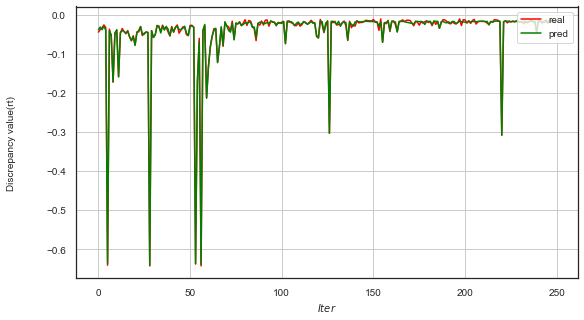

In [917]:
import matplotlib.pyplot as plt

training_results = np.zeros((train_Y.size()[0], 4))

for i in range(train_Y.size()[0]):
    real_obj = train_Y[i,:]
    pred_obj = gp.posterior(train_X[i,:].view(1,-1)).mean
    pred_var = gp.posterior(train_X[i,:].view(1,-1)).variance
    botorchlikelihood = torch.distributions.Normal(loc=pred_obj, scale=pred_var[0]).log_prob(real_obj)
    training_results[i,:] = [i,real_obj.item(),pred_obj[0].item(),botorchlikelihood.item()]


# Draw training curves
# Two curves should almost match together, meaning accurate prediction
font_size_text = 10
fs=10


fig, axs = plt.subplots(1, 1, figsize=(9,5))
axs.plot(training_results[num_init_samples:,0]-num_init_samples, training_results[num_init_samples:,1], color='red', label='real')
axs.plot(training_results[num_init_samples:,0]-num_init_samples, training_results[num_init_samples:,2],'green',label='pred',)
axs.legend(loc=1,fontsize=fs)
axs.grid()
axs.tick_params(axis='both', labelsize=fs)
axs.set_xlabel(r'$Iter$',fontsize=font_size_text)
axs.set_ylabel(r'Discrepancy value(rt)',fontsize=font_size_text,rotation='vertical',labelpad=30)



plt.show()

In [918]:
from scipy.stats import multivariate_normal
#estimate covaraince using the latest candidate
Y_cov = np.zeros((50,1))
index = np.argmax(training_results[:,-1])
X_cov = train_X[index,:].flatten().numpy()
for i in range(50): 
    print(i)
    d_cov = daycare(*X_cov)
    Y_cov[i,:] = distance_bolfi(ss_shannon(d_cov), ss_strains(d_cov), ss_prevalence(d_cov), ss_prevalence_multi(d_cov), observed=obs_summary_list)

cov_est_noise = np.cov(Y_cov, rowvar = False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [919]:
# The approximate likelihood is viewed as approximate posterior now,
# theta : (1*number_of_parameters) parameter point
# The likelihood approximate here is p(y_obs|theta), we have no means to compute likelihood for y!=y_obs, because GP model is trained by y_obs
tol = torch.quantile(train_Y,q=0.8).tolist()# Test quantile tol level vs marginal posterior
print(tol)


-0.016024273261427878


In [920]:
from torch.special import erf
def log_cdf_univariate_normal(x, mean, std):
    """
    Calculates the log CDF of a univariate normal distribution.

    Args:
        x: Input tensor.
        mean: Mean of the distribution.
        std: Standard deviation of the distribution.

    Returns:
        Log CDF of the univariate normal distribution.
    """

    z = (x - mean) / (std * torch.sqrt(torch.tensor(2.0)))
    return torch.log(0.5 * (1+erf(z)))

In [921]:
# The BOLFI approximate likelihood
def approximate_log_likelihood_bolfi(theta,tol=tol,cov_noise=cov_est_noise,gp=gp):
  theta = theta.view(1,-1)
  preds = gp.posterior(theta)
  means, variances = preds.mean, preds.variance
  if torch.isnan(means[0][0]):
      return torch.from_numpy(np.array(-np.Inf).reshape(-1))
  means = means * -1
  Sigma = torch.Tensor([[variances[0].item()]])
  Sigma = Sigma + torch.from_numpy(cov_noise)
  log_likelihood = log_cdf_univariate_normal(-tol, mean = means, std = torch.sqrt(Sigma))
  return log_likelihood

In [922]:
# print(approximate_log_likelihood_bolfi(theta=train_X[-1,:].view(-1))) #Input is defined to be 1d tensor theta
print(approximate_log_likelihood_bolfi(theta=torch.Tensor(true_params).view(-1)))

tensor([[-1.2794]], dtype=torch.float64, grad_fn=<LogBackward0>)


In [923]:
def log_prior_bolfi(theta):# theta is 1d tensor
    
    theta = theta.view(-1)

    for i in range(theta.size()[0]):
        if theta[i]<=lows[i] or theta[i]>=highs[i]:
            return torch.Tensor([-1e12])[0]       
    
    lp_beta = torch.distributions.Uniform(low=lows[0], high=highs[0]).log_prob(theta[0])
    lp_log_lambda = torch.distributions.Uniform(low=lows[1], high=highs[1]).log_prob(theta[1])
    lp_theta = torch.distributions.Uniform(low=lows[2], high=highs[2]).log_prob(theta[2])


    lp = (lp_log_lambda+lp_beta+lp_theta).sum()
    
    
    return lp

In [924]:
log_prior_bolfi(torch.Tensor(true_params).view(-1))

tensor(-2.9957)

In [925]:
#Test prior
priors = np.zeros(train_X.size()[0])
for i in range(train_X.size()[0]):
    param = train_X[i,:].view(-1)
    priors[i] = log_prior_bolfi(param)
df_describe = pd.DataFrame(priors)
prior_median = df_describe.median()
df_describe.describe()


,0
count,2.700000e+02
mean,-2.481481e+11
std,4.327404e+11
min,-1.000000e+12
25%,-2.995732e+00
50%,-2.995732e+00
75%,-2.995732e+00
max,-2.995732e+00


In [926]:
# Test likelihood
likelihoods = np.zeros(train_X.size()[0])
for i in range(train_X.size()[0]):
    param = train_X[i,:].view(-1)
    likelihoods[i] = approximate_log_likelihood_bolfi(param)

df_describe = pd.DataFrame(likelihoods)
df_describe.describe()

,0
count,270.000000
mean,-inf
std,NaN
min,-inf
25%,-9.255164
50%,-1.998150
75%,-0.915324
max,-0.621078


In [927]:
# BOLFI approximate posterior
def approximate_log_posterior_bolfi(theta):
  ll = approximate_log_likelihood_bolfi(theta)
  lprior = log_prior_bolfi(theta)
  lp = lprior + ll
  return lp

In [928]:
approximate_log_posterior_bolfi(torch.Tensor(true_params).view(-1))

tensor([[-4.2751]], dtype=torch.float64, grad_fn=<AddBackward0>)

MOBOLFI

In MOBOLFI, the difference from BOLFI is the design of the dsicrepancy becomes the joint of two partitions: one partition contains the sum of the first and fourth summary, while the other partition contrains the sum of second and third summary. The intuition here is the first and fourth summary somehow measures the diversity of bacteria infection, while the second and the third summary are in fact summarizing the raw data along with different dimension. Besides, our group cannot offer the computation cost for training a four dimensional GP model.

In [886]:
def distance_mobolfi(*summaries, observed):
    """Calculate an L1-based distance between the simulated and observed summaries.

    Follows the simplified single-distance approach in:
    Gutmann M U, Corander J (2016). Bayesian Optimization for Likelihood-Free Inference
    of Simulator-Based Statistical Models. JMLR 17(125):1−47, 2016.

    Parameters
    ----------
    *summaries : k np.arrays of shape (m, n)
    observed : list of k np.arrays of shape (1, n)

    Returns
    -------
    np.array of shape (m,)

    """
    summaries = np.stack(summaries)
    observed = np.stack(observed)
    n_ss, _, n_dcc = summaries.shape

    obs_max = np.max(observed, axis=2, keepdims=True)
    obs_max = np.where(obs_max == 0, 1, obs_max)

    y = observed / obs_max
    x = summaries / obs_max

    # sort to make comparison more robust
    y = np.sort(y, axis=2)
    x = np.sort(x, axis=2)
    # L1 norm divided by the dimension
    dist = np.sum(np.abs(x - y), axis=2) / (n_ss * n_dcc)
    dist[3] *= 0.1 # Same scaling as done in BOLFI
    # print(np.array([dist[0],dist[1],dist[2],dist[3]])) # You can uncomment this and try MOBOLFI with four objectives, but be careful the training is very time consuming!
    dist_update = np.array([dist[0]+dist[3],dist[1]+dist[2]])
    return dist_update.reshape(1,-1)*-10

In [887]:
obs_summary_list = [ss_shannon(real_data), ss_strains(real_data), ss_prevalence(real_data), ss_prevalence_multi(real_data)]
test_params = [4.6, 0.6, 0.1]
test_data = daycare(*test_params)
distance_mobolfi(ss_shannon(test_data), ss_strains(test_data), ss_prevalence(test_data), ss_prevalence_multi(test_data), observed=obs_summary_list)

array([[-0.05723927, -0.16290568]])

In [19]:
test_params = true_params
test_data = daycare(*test_params)
real_d = distance_mobolfi(ss_shannon(test_data), ss_strains(test_data), ss_prevalence(test_data), ss_prevalence_multi(test_data), observed=obs_summary_list)
real_d

array([[-0.05689376, -0.16590038]])

In [817]:
num_init_samples = 20
# Write function that generates training data with larger range
def init_sample_generator_mobolfi(num_init_samples = num_init_samples):
    init_sample_param = np.zeros((num_init_samples, 3)) # theta dim 3
    init_sample_discrepancy = np.zeros((num_init_samples, 2)) # discrepancy dim
    i = 0
    while i < num_init_samples:
        print(i)
        init_theta = np.random.rand(3)
        init_theta[0] *= 10
        init_theta[1] *= 2
        init_data = daycare(*init_theta)
        init_discrepancy = distance_mobolfi(ss_shannon(init_data), ss_strains(init_data), ss_prevalence(init_data), ss_prevalence_multi(init_data), observed=obs_summary_list)
        init_sample_param[i,:] = init_theta
        init_sample_discrepancy[i,:] = init_discrepancy
        i += 1

    return init_sample_param,init_sample_discrepancy


In [818]:
init_sample_param_mobolfi,init_sample_discrepancy_mobolfi = init_sample_generator_mobolfi()
print(pd.DataFrame(init_sample_discrepancy_mobolfi).describe())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
               0          1
count  20.000000  20.000000
mean   -0.791172  -1.424358
std     0.272452   0.442922
min    -1.174331  -2.008747
25%    -1.056389  -1.830840
50%    -0.807521  -1.427907
75%    -0.583415  -1.128877
max    -0.218849  -0.549780


In [1400]:
# See best points in initial training data
print(init_sample_param_mobolfi[np.argmax(init_sample_discrepancy_mobolfi[:,0]),:])
print(init_sample_param_mobolfi[np.argmax(init_sample_discrepancy_mobolfi[:,1]),:])
print(init_sample_discrepancy_mobolfi[np.argmax(init_sample_discrepancy_mobolfi[:,0]),:])
print(init_sample_discrepancy_mobolfi[np.argmax(init_sample_discrepancy_mobolfi[:,1]),:])

[6.58692262 1.27712657 0.0475252 ]
[3.28904576 1.56929813 0.02168655]
[-0.04149984 -0.2082136 ]
[-0.10905633 -0.11003352]


In [731]:
X_mobolfi = torch.from_numpy(init_sample_param_mobolfi)
Y_mobolfi = torch.from_numpy(init_sample_discrepancy_mobolfi)
train_X_mobolfi = X_mobolfi.double()
train_Y_mobolfi = Y_mobolfi.double()

In [673]:
bounds = torch.tensor([lows,highs],dtype=torch.double)
ref_point = list(init_sample_discrepancy_mobolfi.min(axis=0)-0.01)
ref_point

[-0.446865161076683, -0.676187739463602]

In [732]:
start_time = time.time()
warnings.filterwarnings("ignore")

number_of_iterGPtraining = 1 # = 50 150 250 increase it until prediction discrepancy decreases, note MOBOLFI training costs much more time than BOLFI training

for i in range(number_of_iterGPtraining):
    # For each iteration, train the GP model using current training data
    gp_mobolfi = SingleTaskGP(train_X_mobolfi, train_Y_mobolfi)
    mll_mobolfi = ExactMarginalLogLikelihood(gp_mobolfi.likelihood, gp_mobolfi)
    fit_gpytorch_mll(mll_mobolfi)

    # Define the acuisition function using current training data
    qNEHVI = qNoisyExpectedHypervolumeImprovement(gp_mobolfi, ref_point, train_X_mobolfi)

    candidate_mobolfi, acq_value_mobolfi = optimize_acqf(
      qNEHVI, bounds=bounds, q=1, num_restarts=40, raw_samples=100,)


    # Include new acuisition into training data
    train_X_mobolfi = torch.cat((train_X_mobolfi, candidate_mobolfi)).double()
    candidate_X_mobolfi = candidate_mobolfi.flatten().numpy()
    candidate_Y_data_mobolfi = daycare(*candidate_X_mobolfi)
    candidate_Y_mobolfi = distance_mobolfi(ss_shannon(candidate_Y_data_mobolfi), ss_strains(candidate_Y_data_mobolfi), ss_prevalence(candidate_Y_data_mobolfi),
                                    ss_prevalence_multi(candidate_Y_data_mobolfi), observed=obs_summary_list)
    candidate_Y_mobolfi = torch.Tensor([candidate_Y_mobolfi]).view(1,-1)
    train_Y_mobolfi = torch.cat((train_Y_mobolfi, candidate_Y_mobolfi)).double()

    # Print the newest proposed parameter point and corresponding acuisition function value, real discrepancies and predicted discrepancies (mean)
    if i % 10 == 0:
        print("Iteration: {}\t".format(i+1))
        print("New parameter point: {}\t".format(candidate_mobolfi.tolist()))
        print("Acuisition function value: {}\t".format(acq_value_mobolfi.item()))
        print("Real discrepancy result: {}\t".format(candidate_Y_mobolfi.tolist()))
        print("Predicted discrepancy result: {}\t".format(gp_mobolfi.posterior(candidate_mobolfi).mean.tolist()))




print("Running time for GP training: --- %s seconds ---" % (time.time() - start_time))


Iteration: 1	
New parameter point: [[0.0, 0.49730929290633813, 0.25561157020218483]]	
Acuisition function value: 0.000999419927304751	
Real discrepancy result: [[-0.16450141370296478, -0.6507775783538818]]	
Predicted discrepancy result: [[-0.12297691036295363, -0.45160258835385253]]	
Running time for GP training: --- 65.2594723701477 seconds ---


In [845]:
print(gp_mobolfi.posterior(torch.Tensor(true_params).view(1,-1)).mean)
gp_mobolfi.posterior(train_X_mobolfi[-1,:].view(1,-1)).mean

tensor([[-0.0634, -0.1413]], dtype=torch.float64, grad_fn=<TransposeBackward0>)


tensor([[-0.2372, -0.7828]], dtype=torch.float64, grad_fn=<TransposeBackward0>)

In [734]:
training_results_mobolfi = np.zeros((train_Y_mobolfi.size()[0], 6))

for i in range(train_Y_mobolfi.size()[0]):
    real_obj = train_Y_mobolfi[i,:]
    pred_obj = gp_mobolfi.posterior(train_X_mobolfi[i,:].view(1,-1)).mean
    pred_var = gp_mobolfi.posterior(train_X_mobolfi[i,:].view(1,-1)).variance
    botorchlikelihood1 = torch.distributions.Normal(loc=pred_obj[0][0], scale=pred_var[0][0]).log_prob(real_obj[0])
    botorchlikelihood2 = torch.distributions.Normal(loc=pred_obj[0][1], scale=pred_var[0][1]).log_prob(real_obj[1])
    # botorchlikelihood3 = torch.distributions.Normal(loc=pred_obj[0][2], scale=pred_var[0][2]).log_prob(real_obj[2])
    # botorchlikelihood4 = torch.distributions.Normal(loc=pred_obj[0][3], scale=pred_var[0][3]).log_prob(real_obj[3])
    botorchlikelihood = botorchlikelihood1+botorchlikelihood2
    training_results_mobolfi[i,:] = [i,real_obj[0].item(),real_obj[1].item(),
                             pred_obj[0][0].item(),pred_obj[0][1].item(),botorchlikelihood.item()]

training_results_mobolfi

array([[ 0.00000000e+00, -2.50743698e-01, -4.23491379e-01,
        -2.59029002e-01, -4.20574551e-01, -4.47346411e+01],
       [ 1.00000000e+00, -1.09056326e-01, -1.10033525e-01,
        -1.85962653e-01, -1.99220053e-01, -5.75678011e+04],
       [ 2.00000000e+00, -2.67637876e-01, -5.17600575e-01,
        -2.66903779e-01, -5.18604603e-01,  1.09929321e+01],
       [ 3.00000000e+00, -4.14998384e-02, -2.08213602e-01,
        -8.57197841e-02, -2.52738464e-01, -1.44673114e+04],
       [ 4.00000000e+00, -2.38093034e-01, -2.55866858e-01,
        -2.39312956e-01, -2.71753886e-01, -2.76031940e+01],
       [ 5.00000000e+00, -3.12313002e-01, -4.43247126e-01,
        -3.14516009e-01, -4.43100910e-01,  7.94086332e+00],
       [ 6.00000000e+00, -4.02762294e-01, -6.23682950e-01,
        -3.93841769e-01, -6.15705351e-01, -5.80241340e+01],
       [ 7.00000000e+00, -1.15865559e-01, -5.13529693e-01,
        -1.28060584e-01, -5.09247188e-01, -9.92517337e+01],
       [ 8.00000000e+00, -3.10828693e-01, -4.944

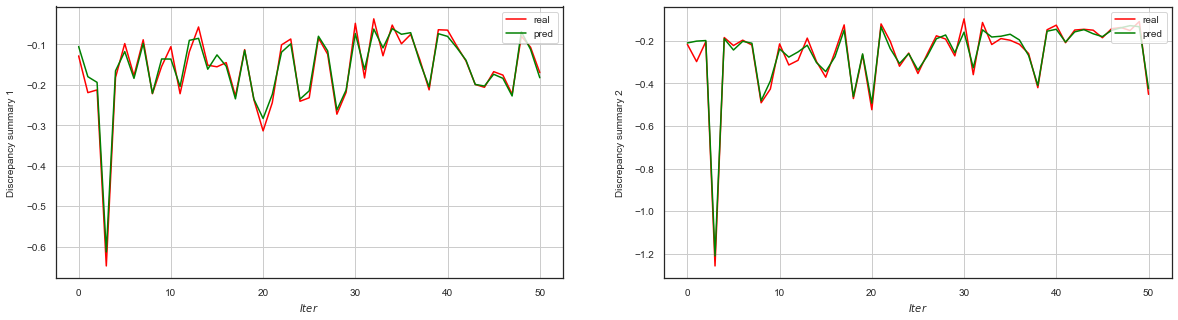

In [622]:
# Draw training curves
# Two curves should almost match together, meaning accurate prediction
font_size_text = 10
fs=10


fig, axs = plt.subplots(1, 2, figsize=(20,5))
axs[0].plot(training_results_mobolfi[num_init_samples:,0]-num_init_samples, training_results_mobolfi[num_init_samples:,1], color='red', label='real')
axs[0].plot(training_results_mobolfi[num_init_samples:,0]-num_init_samples, training_results_mobolfi[num_init_samples:,3],'green',label='pred',)
axs[0].legend(loc=1,fontsize=fs)
axs[0].grid()
axs[0].tick_params(axis='both', labelsize=fs)
axs[0].set_xlabel(r'$Iter$',fontsize=font_size_text)
axs[0].set_ylabel(r'Discrepancy summary 1',fontsize=font_size_text,rotation='vertical',labelpad=10)

axs[1].plot(training_results_mobolfi[num_init_samples:,0]-num_init_samples, training_results_mobolfi[num_init_samples:,2], color='red', label='real')
axs[1].plot(training_results_mobolfi[num_init_samples:,0]-num_init_samples, training_results_mobolfi[num_init_samples:,4],'green',label='pred')
axs[1].legend(loc=1,fontsize=fs)
axs[1].grid()
axs[1].tick_params(axis='both', labelsize=fs)
axs[1].set_xlabel(r'$Iter$',fontsize=font_size_text)
axs[1].set_ylabel(r'Discrepancy summary 2',fontsize=font_size_text,rotation='vertical',labelpad=10)


plt.show()

In [735]:
#estimate covaraince using the latest candidate
Y_cov_mobolfi = np.zeros((50,2))
index = np.argmax(training_results_mobolfi[:,-1])
X_cov_mobolfi = train_X_mobolfi[index,:].flatten().numpy()
for i in range(50): 
    print(i)
    d_cov_mobolfi = daycare(*X_cov_mobolfi)
    Y_cov_mobolfi[i,:] = distance_mobolfi(ss_shannon(d_cov_mobolfi), ss_strains(d_cov_mobolfi), ss_prevalence(d_cov_mobolfi), ss_prevalence_multi(d_cov_mobolfi), observed=obs_summary_list)

cov_est_noise_mobolfi = np.cov(Y_cov_mobolfi, rowvar = False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [736]:
cov_est_noise_mobolfi

array([[ 0.00029896, -0.00021076],
       [-0.00021076,  0.00073649]])

We offer two ways to calculate the MOBOLFI approximate likelihood. One is to use scipy.multivariate_normal().logcdf(). The calculation is faster but the output Tensor has no gradient. The other way is to use Gaussian quadrature function in log_cdf_bivariate_normal(), which is the idea that scipy.multivariate_normal().logcdf() is based on. Here we offer a simple version of Gaussian quadrature approxiamtion, with size 100 points calculating the Rieman sum. The output likelihood value has a gradient and can be used by other MCMC packages in python. However, log_cdf_bivariate_normal() requires more time in computation.

In [864]:
def log_cdf_bivariate_normal(x, mean, cov):
    """
    Approximates the log CDF of a bivariate normal distribution using Gaussian quadrature.

    Args:
        x: Input tensor of shape (2,).
        mean: Mean vector of the distribution.
        cov: Covariance matrix of the distribution.

    Returns:
        Log CDF of the bivariate normal distribution.
    """

    def bivariate_normal_pdf(y, mean, cov):
        """Bivariate normal probability density function."""
        diff = y - mean
        exponent = -0.5 * torch.matmul(diff.T, torch.matmul(torch.inverse(cov), diff)).double()
        return torch.exp(exponent) / (2 * torch.pi * torch.sqrt(torch.det(cov)))

    # Gaussian quadrature points and weights (adjust order for accuracy)
    def gauss_legendre_quadrature(n):
        x, w = np.polynomial.legendre.leggauss(n)
        return torch.tensor(x), torch.tensor(w)

    # Apply Gaussian quadrature in both dimensions
    def integrate(f, a, b, n):
        x, w = gauss_legendre_quadrature(n)
        s = torch.zeros(1,1)
        for i in range(n):
            xi = (b - a) * x[i] / 2 + (b + a) / 2
            wi = w[i] * (b - a) / 2
            yi = f(xi)
            s += wi[0] * wi[1] * yi
        return s

    # Integration limits (adjust as needed)
    lower_limit = torch.tensor([-10, -10], dtype=torch.double, requires_grad=True)
    upper_limit = x.clone().requires_grad_()

    cdf = integrate(lambda y: bivariate_normal_pdf(y, mean, cov), lower_limit, upper_limit, 100)
    log_cdf = torch.log(cdf)
    return log_cdf

# Example usage with gradient calculation
x = torch.tensor([2.0, 3.0], requires_grad=True)
mean = torch.tensor([0.1, 0.0])
cov = torch.tensor([[1.0, 0.5], [0.5, 1.0]]).double()

log_cdf = log_cdf_bivariate_normal(x, mean, cov)
log_cdf


tensor([[-3.2117]], grad_fn=<LogBackward0>)

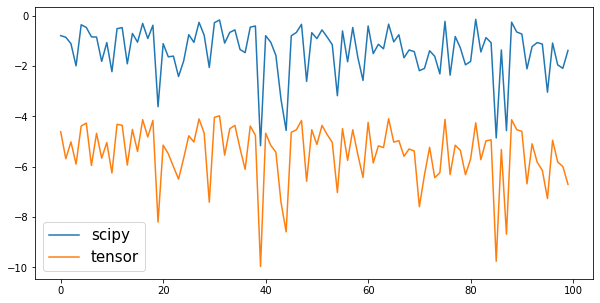

In [56]:
# # Show that the log_cdf_bivariate_normal() is approximately equal to the multivariate_normal().logcdf() in scipy package plus a constant
# from scipy.stats import multivariate_normal

# scipycdf=[]
# tensorcdf=[]

# for i in range(100):
#     x = torch.randn(2)
#     scipycdf.append(multivariate_normal(mean=mean.detach().numpy(), cov=cov.detach().numpy()).logcdf(x.detach().numpy()))
#     tensorcdf.append(log_cdf_bivariate_normal(x, mean, cov).item())


# fig, axs = plt.subplots(1, 1, figsize=(10,5))

# for i in range(1):
#     axs.plot(list(range(100)), scipycdf,label='scipy')
#     axs.plot(list(range(100)), tensorcdf,label='tensor')
#     axs.legend(fontsize=15)

In [888]:
# The approximate likelihood is viewed as approximate posterior now,
# theta : (1*number_of_parameters) parameter point
# The likelihood approximate here is p(y_obs|theta), we have no means to compute likelihood for y!=y_obs, because GP model is trained by y_obs
tol_mobolfi = torch.quantile(train_Y_mobolfi,q=0.95,dim=0).tolist()# Test quantile tol level vs marginal posterior, approx ll is very sensitive to tol level!
print(tol_mobolfi)

# def approximate_log_likelihood_mobolfi(theta,tol=tol_mobolfi,cov_noise=cov_est_noise_mobolfi,gp=gp_mobolfi,covariance=0):
#   theta = theta.view(1,-1)
#   preds = gp.posterior(theta)
#   means, variances = preds.mean, preds.variance
#   if torch.isnan(means[0][0]) or torch.isnan(means[0][1]):
#       return torch.from_numpy(np.array(-np.Inf).reshape(-1))
#   means =  means[0] * -1
#   Sigma = torch.Tensor([[variances[0][0],covariance],
#                          [covariance,variances[0][1]]])
#   Sigma = Sigma + torch.from_numpy(cov_noise)
#   Sigma = Sigma.double()
  
#   log_likelihood = log_cdf_bivariate_normal(torch.Tensor([-tol[0], -tol[1]]), mean = means, cov=Sigma)
#   return log_likelihood


from scipy.stats import multivariate_normal

def approximate_log_likelihood_mobolfi(theta,tol=tol_mobolfi,cov_noise=cov_est_noise_mobolfi,gp=gp_mobolfi,covariance=0):
  theta = theta.view(1,-1)
  preds = gp.posterior(theta)
  means, variances = preds.mean, preds.variance
  means = means.view(-1).detach().numpy() * -1
  Sigma = np.array([[variances[0][0].item(),covariance],
                    [covariance,variances[0][1].item()]])
  cov_matrix = cov_noise + Sigma
  mulnorm = multivariate_normal(mean=means, cov=cov_matrix)
  log_likelihood = torch.Tensor([mulnorm.logcdf([-tol[0],-tol[1]])]).reshape(-1)
  return log_likelihood


In [889]:
print(approximate_log_likelihood_mobolfi(theta=torch.Tensor(true_params).view(-1))) # should be large and larger than value of the chunk above

tensor([-2.3934])


In [1627]:
#Test likelihood
lls_mobolfi = np.zeros(train_X_mobolfi.size()[0])
for i in range(train_X_mobolfi.size()[0]):
    param = train_X_mobolfi[i,:].view(-1)
    lls_mobolfi[i] = approximate_log_likelihood_mobolfi(param)

df_describe = pd.DataFrame(lls_mobolfi)
df_describe.describe()

,0
count,270.000000
mean,-inf
std,NaN
min,-inf
25%,-74.511675
50%,-34.300365
75%,-13.435663
max,-2.807836


In [1628]:
#Test prior
priors = np.zeros(train_X_mobolfi.size()[0])
for i in range(train_X_mobolfi.size()[0]):
    param = train_X_mobolfi[i,:].view(-1)
    priors[i] = log_prior_bolfi(param)

df_describe = pd.DataFrame(priors)
prior_median = df_describe.median()
df_describe.describe()

,0
count,2.700000e+02
mean,-3.407407e+11
std,4.748385e+11
min,-1.000000e+12
25%,-1.000000e+12
50%,-2.995732e+00
75%,-2.995732e+00
max,-2.995732e+00


In [890]:
def approximate_log_posterior_mobolfi(theta):
  ll = approximate_log_likelihood_mobolfi(theta)
  lprior = log_prior_bolfi(theta)
  lp = lprior + ll
  return lp

In [891]:
approximate_log_posterior_mobolfi(theta=torch.Tensor(true_params).view(-1))

tensor([-5.3891])

Importance Sampling

We use important sampling to present the BOLIF/MOBOLFI approximate posterior with an auxiliary pdf multivariate t with degree of freedom 3. In BOLFI paper, the author sued an iterative importance sampling method that changes the auxiliary pdf iterative depending on last proposal.

If you want to use other MCMC sample methods that is based on Pytorch, do use the commented approximate likelihood function based on log_cdf_bivariate_normal() above. That function has its out put with gradient in tensor form.

In [929]:
# Importance sampling of BOLFI
M = 20000 # sample size
N = 1 # simulation size, no need to be so large due to asymptotics

from scipy.stats import multivariate_t

aux_q = multivariate_t(loc = [5, 1, 0.5], df=3)

h = torch.Tensor([-0.6])

# Auxiliary distribution sample
aux_q_samples_bolfi = torch.zeros((M,3))
aux_q_samples_importance_bolfi = torch.zeros(M)
i = 0 
while i < M:
    aux_q_sample_bolfi = aux_q.rvs(size=1)
    importance_q_sample_bolfi = torch.zeros(1)
    observed_distance_q_sample_bolfi = gp.posterior(torch.Tensor(aux_q_sample_bolfi).view(1,-1)).mean
    if observed_distance_q_sample_bolfi[0][0].item() >= h[0].item():  
        importance_q_sample_bolfi += torch.exp(torch.Tensor([approximate_log_posterior_bolfi(theta=torch.Tensor(aux_q_sample_bolfi).view(-1)).item()-aux_q.logpdf(aux_q_sample_bolfi).item()]))
        aux_q_samples_importance_bolfi[i] = importance_q_sample_bolfi
        aux_q_samples_bolfi[i,:] = torch.from_numpy(aux_q_sample_bolfi)
        i += 1
        if i % 1000 == 0:
            print(i)


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


In [930]:
index_bolfi = torch.where(aux_q_samples_importance_bolfi > 0) # Since theta outside the uniform prior returns -1e12, a rejection should be done here to remove those invlaid thetas.
aux_q_samples_importance_bolfi = aux_q_samples_importance_bolfi[index_bolfi]
aux_q_samples_bolfi = aux_q_samples_bolfi[index_bolfi]
print(aux_q_samples_bolfi.size())

torch.Size([3994, 3])


In [892]:
# Importance sampling of MOBOLFI
M = 20000 # sample size
N = 1 # simulation size, no need to be so large due to asymptotics

h = torch.Tensor([-0.6, -0.6])

from scipy.stats import multivariate_t

aux_q = multivariate_t(loc = [5, 1, 0.5], df=3)


# Auxiliary distribution sample
aux_q_samples = torch.zeros((M,3))
aux_q_samples_importance = torch.zeros(M)
i = 0 
while i < M:
    aux_q_sample = aux_q.rvs(size=1)
    importance_q_sample = torch.zeros(1)
    observed_distance_q_sample = gp_mobolfi.posterior(torch.Tensor(aux_q_sample).view(1,-1)).mean
    if observed_distance_q_sample[0][0].item() >= h[0].item() and observed_distance_q_sample[0][1].item() >= h[1].item():  
        importance_q_sample += torch.exp(torch.Tensor([approximate_log_posterior_mobolfi(theta=torch.Tensor(aux_q_sample).view(-1)).item()-aux_q.logpdf(aux_q_sample).item()]))
        aux_q_samples_importance[i] = importance_q_sample
        aux_q_samples[i,:] = torch.from_numpy(aux_q_sample)
        i += 1
        if i % 1000 == 0:
            print(i)



1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


In [893]:
index = torch.where(aux_q_samples_importance > 0) # Since theta outside the uniform prior returns -1e12, a rejection should be done here to remove those invlaid thetas.
aux_q_samples_importance = aux_q_samples_importance[index]
aux_q_samples = aux_q_samples[index]
print(aux_q_samples.size())

torch.Size([13486, 3])


The idea of announcing "weights" in kdeplot():

Suppose we want to visual the target distribution density $p(\theta)$, i.e. approxiamte popsterior in our work.
By importance sampling, $\int p(\theta)p(\theta)d\theta$ can be approximated by $1/M*\sum_{m=1}^M(p(\theta)/q(\theta))*p(\theta)$, where $q(\theta)$ is the auxiliary pdf. In this example we define it to be a fat tailed t-distribution. $M$ is the size of sample from auxiliary pdf.
In the summation above, $p(\theta)/q(\theta)$ is the importance weight of $\theta$ sampling from $q(\theta)$. The $p(\theta)$ is estimated using kernel density estimate from seaborn, by using sample $\theta$ from approximate posterior $p(\theta)$. A rejection criteria is applied to reject $\theta$ with corresponding discrepancy value too large (equivalently negative discrepancy too small). Note that applying such rejection is in fact doing a classic rejection ABC sampling, by viewing $q(\theta)$ as the "prior" for ABC. Therefore, the actual auxiliary pdf here is $q(\theta)*I_{\Delta<threshold}$. After obtaining kde of $p(\theta)$, we times each estimate with its corresponding importances weight (set argument "weights" to be importance weight).

This sampling method has been mentioned in Sec 3.5 from the BOLFI paper (https://jmlr.org/papers/v17/15-017.html), and was firstly proposed by (Wood, 2010) https://www.nature.com/articles/nature09319, who used synthetic likelihood with MH-sampling for posterior approximation.


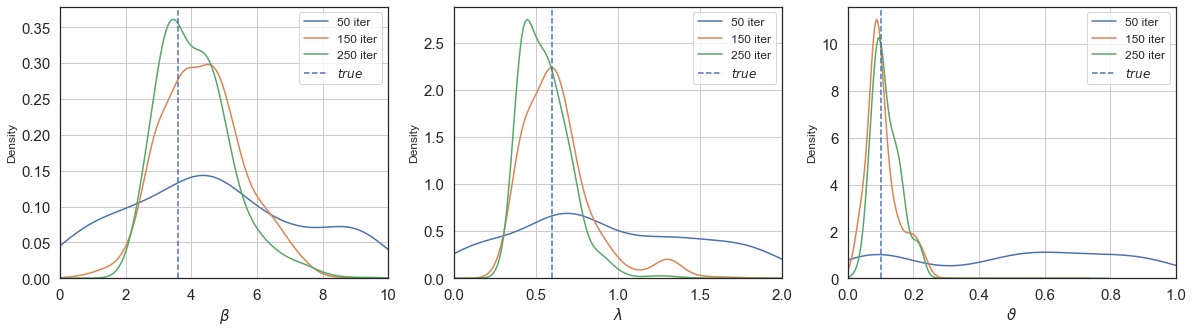

In [830]:
# MOBOLFI vs iter
font_size_text = 15
fs = 15

theta_list = [r'$\beta$',r'$\lambda$',r'$\vartheta$']
fig, axs = plt.subplots(1, 3, figsize=(20,5))

for i in range(3):
     # weights here is the imporatnce weight for each sample point, values of weights are mapped to 0-1 by dividing the sum of weights of all sample points.
     sns.kdeplot(aux_q_samples_50iter[:,i], ax=axs[i], weights=aux_q_samples_importance_50iter/torch.sum(aux_q_samples_importance_50iter), label='50 iter', bw_adjust=1)
     sns.kdeplot(aux_q_samples_150iter[:,i], ax=axs[i], weights=aux_q_samples_importance_150iter/torch.sum(aux_q_samples_importance_150iter), label='150 iter', bw_adjust=1)
     sns.kdeplot(aux_q_samples[:,i], ax=axs[i], weights=aux_q_samples_importance/torch.sum(aux_q_samples_importance), label='250 iter', bw_adjust=1)
     axs[i].axvline(true_params[i],0,1,linestyle="--",label='$true$')
     axs[i].legend(fontsize=fs-3)
     axs[i].grid()
     axs[i].set_xlim([lows[i],highs[i]])
     axs[i].tick_params(axis='both', labelsize=fs)
     axs[i].set_xlabel(theta_list[i],fontsize=font_size_text)

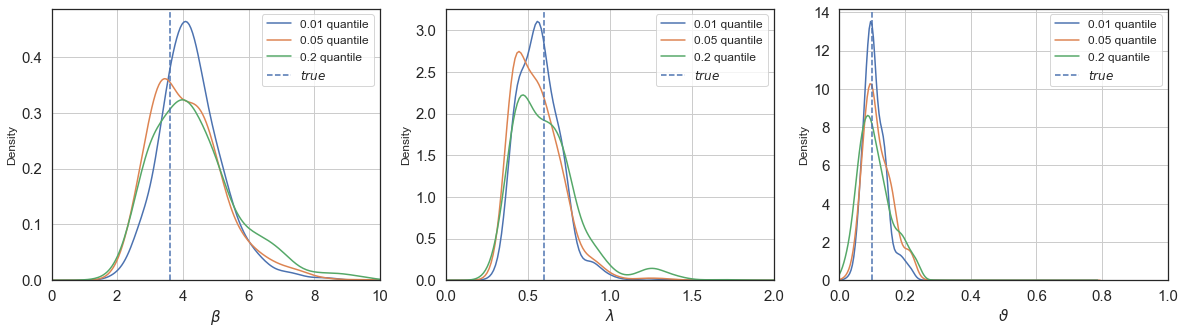

In [829]:
# MOBOLFI vs tol
font_size_text = 15
fs = 15

theta_list = [r'$\beta$',r'$\lambda$',r'$\vartheta$']
fig, axs = plt.subplots(1, 3, figsize=(20,5))

for i in range(3):
     sns.kdeplot(aux_q_samples_1tol[:,i], ax=axs[i], weights=aux_q_samples_importance_1tol/torch.sum(aux_q_samples_importance_1tol), label='0.01 quantile', bw_adjust=1)
     sns.kdeplot(aux_q_samples[:,i], ax=axs[i], weights=aux_q_samples_importance/torch.sum(aux_q_samples_importance), label='0.05 quantile', bw_adjust=1)   
     sns.kdeplot(aux_q_samples_20tol[:,i], ax=axs[i], weights=aux_q_samples_importance_20tol/torch.sum(aux_q_samples_importance_20tol), label='0.2 quantile', bw_adjust=1)
     axs[i].axvline(true_params[i],0,1,linestyle="--",label='$true$')
     axs[i].legend(fontsize=fs-3)
     axs[i].grid()
     axs[i].set_xlim([lows[i],highs[i]])
     axs[i].tick_params(axis='both', labelsize=fs)
     axs[i].set_xlabel(theta_list[i],fontsize=font_size_text)

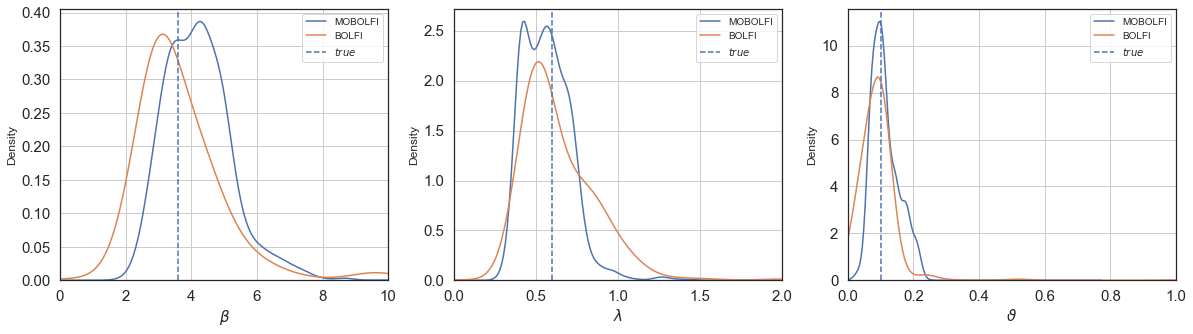

In [933]:
# MOBOLFI vs BOLFI
font_size_text = 15
fs = 15

theta_list = [r'$\beta$',r'$\lambda$',r'$\vartheta$']
fig, axs = plt.subplots(1, 3, figsize=(20,5))

for i in range(3):
     sns.kdeplot(aux_q_samples[:,i], ax=axs[i], weights=aux_q_samples_importance/torch.sum(aux_q_samples_importance), label='MOBOLFI', bw_adjust=0.8)
     sns.kdeplot(aux_q_samples_bolfi[:,i], ax=axs[i], weights=aux_q_samples_importance_bolfi/torch.sum(aux_q_samples_importance_bolfi), label='BOLFI', bw_adjust=0.8)
     axs[i].axvline(true_params[i],0,1,linestyle="--",label='$true$')
     axs[i].legend(fontsize=fs-5)
     axs[i].grid()
     axs[i].set_xlim([lows[i],highs[i]])
     axs[i].tick_params(axis='both', labelsize=fs)
     axs[i].set_xlabel(theta_list[i],fontsize=font_size_text)